In [1]:
import json
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import datetime
from ast import literal_eval
import SimpleITK as sitk

from MRLCinema.doseaccumulation.fraction_dose import dose_accumulation
from QAckis.Logfiles.Logfile import Logfile
from U2Dose.patient.Roi import Roi
from U2Dose.geometry.Grid3D import Grid3D

motion_management_result_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/MotionManagement'
patient_data_root = r'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
patient_data_archive_root = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Patient_Data_Archive'
logfile_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles'
logfile_path_archive = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles_archive'

predcited_dose_path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/MarginSimulation/rois_predicted_doses'


# Plan &rarr; Verification displacements from 3D images
Read registration results that was previously made for Plan to Verification 3D images

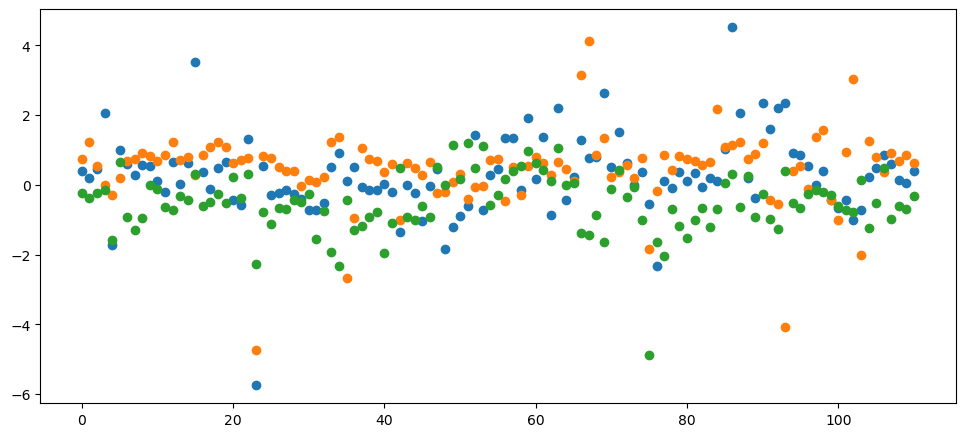

In [2]:
result_filename = '/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/PatientData/motion_analysis/verification_vs_planning/result.txt'
plan_ver_data = np.loadtxt(result_filename)
num_regs = len(plan_ver_data)

plan_ver_displacements = []


for row in plan_ver_data:
    patient = int(row[0])
    fraction = int(row[1])
    delta_pos = np.array(row[2:5])
    plan_ver_displacements.append(delta_pos)
plan_ver_displacements = np.array(plan_ver_displacements)

f, ax = plt.subplots(figsize=(30/2.54, 13/2.54), sharex=True)
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,0], label='X Displacement')
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,1], label='Y Displacement')
ax.scatter(range(len(plan_ver_displacements)), plan_ver_displacements[:,2], label='Z Displacement')




# Support functions

In [14]:

def dose_at_volume(dose, mask, rel_volume):
    dose_values = dose[mask > 0]
    dose_values = np.sort(dose_values)
    volume = mask.sum()
    if rel_volume > 1:
        raise ValueError("Volume must be between 0 and 1")    
    index = int((1-rel_volume) * volume)
    return dose_values[index]

def volume_at_dose(dose, mask, dose_threshold):
    return np.sum(dose > dose_threshold) / np.sum(mask > 0)

def read_report(filename):
    with open(filename, 'r') as file:
        report = json.load(file)
    return report

def has_logfile_terminated_fault(logfile:Logfile) -> bool:
    """
    Check if the logfile has been terminated properly.
    """
    indices_terminated_fault = np.argwhere(logfile.linac_states == b'Terminated Fault')
    if len(indices_terminated_fault) == 0:
        return False
    return True

def xx_filenames(patient, fraction, pattern='RP*.dcm'):
    filenames = glob.glob(os.path.join(patient_data_root, patient, fraction, pattern))
    if len(filenames) == 0:
        filenames = glob.glob(os.path.join(patient_data_archive_root, patient, fraction, pattern)) 
    return filenames

def read_logfile(patient_ID, plan_label):
    filenames = xx_filenames(patient_ID, plan_label, '*logfile.txt')
    
    logfile = None
    
    if len(filenames) == 0:
        return None

    with open(filenames[0] , 'r') as file:
        logfile_report = json.load(file)
        date = datetime.datetime.strptime(logfile_report['rtplan_datetime'][:-6], '%Y-%m-%d %H:%M:%S').date()

        filename = logfile_report['log_filename']
        if filename.startswith('/home/funk0370'):
            filename = filename.replace('/home/funk0370', '/mnt/P/TERAPI/MRLINAC/QA')
            
        logfile = Logfile.from_csv(filename)
        
        if logfile is not None:
            if has_logfile_terminated_fault(logfile):
                return None

    return logfile


def find_start_index(cine_times, treatment_time):
    """
    Find the index in cine_times where the treatment time starts.
    if cine times are longer than treatment times, assume that the treatment is during the end of the cines.
    param cine_times: The list of cine times.
    param treatment_time: The treatment time.
    returns: The index where the treatment time starts.
    """
    if np.max(cine_times) > treatment_time:
        time_discard = np.max(cine_times) - treatment_time
        transversal_start_index = np.argmax(cine_times >= time_discard) 
    else:
        transversal_start_index = 0 
    
    return transversal_start_index




## Read motion traces to simulate
- After 2024-10-01
- Logfile must exist (if treatment was aborted then not there)
- Motion trace should be at least the length of the treatment time

In [4]:
filenames = glob.glob(os.path.join(motion_management_result_path, '*.json'))
reports = [read_report(filename) for filename in filenames]
reports = {(report['PatientID'], report['PlanLabel']): report for report in reports}  


#
# Read all treatments that will be part of simulation
#
treatments_str = None
with open('../treatment_info_late.json', "r") as f:
    treatments_str = json.load(f)  
treatments = {literal_eval(key): literal_eval(value) for key, value in treatments_str.items()} 


# Sample whole fraction displacements and accumulate the dose
1. Sample a Plan to Verification displacement
2. Offset cine trace with the sampled displacement
3. read the CTV
4. Add the PTV
5. Predict the dose
6. Accumulate the dose under motion

Do this many times for statistsics!


In [27]:
import pandas
from IPython.display import display, HTML

from visualisation.fraction_cinema.business_logic import read_rtss

def read_roi(patient_id, plan_label, name):
    filename = os.path.join(predcited_dose_path, f'{name}_{patient_id}_{plan_label}.npz')
    mask = np.load(filename)['arr_0']
    mask = mask.astype(int)
    grid_filename = os.path.join(predcited_dose_path, f'grid_{patient_id}_{plan_label}_grid.json')
    grid_dict = None
    with open(grid_filename, 'r') as f:
        grid_dict = json.load(f)
    grid = Grid3D(np.array(grid_dict['pos_000']), np.array(grid_dict['spacing']), np.array(grid_dict['dim']))
    roi = Roi(grid, mask, name)
    return roi

def read_ctv(patient_id, plan_label):
    return read_roi(patient_id, plan_label, 'CTV')

def read_ptv(patient_id, plan_label):
    return read_roi(patient_id, plan_label, 'PTV')

def read_predict_dose(patient_id, plan_label):
    filename = os.path.join(predcited_dose_path, f'predicted_dose_{patient_id}_{plan_label}.npz')
    dose = np.load(filename)['arr_0']
    return dose


def sample_plane_ver(plan_ver_displacements) -> np.array:
    num_fx = len(plan_ver_displacements)
    sample = np.random.randint(0, num_fx, size=1)
    return plan_ver_displacements[sample[0]]


def sample_cine(treatment_infos, reports) -> dict:
    """
    Sample a random cine trace from the reports.
    Returns a tuple containing the report, treatment time, and the sampled displacement data.
    """
    num_reports = len(treatment_infos)
    sample = np.random.randint(0, num_reports)
    key = list(treatment_infos.keys())[sample]
    report = reports[key]
    return report

def do_atp(plane_ver_displacement, atp_limit) -> bool:
    if np.any(plane_ver_displacement < atp_limit[:, 0]) or np.any(plane_ver_displacement > atp_limit[:, 1]):
        return True
    return False

def interpolate_displacement(times_src, positions_src, times):
    return np.interp(times, times_src, positions_src)

def combine_traces(trace_0, trace_1):
    if len(trace_0) != len(trace_1):
        raise ValueError("Traces must have the same shape to be combined.")
    combined_trace = np.zeros(len(trace_0))
    for i in range(len(trace_0)):
        if abs(trace_0[i]) > abs(trace_1[i]):
            combined_trace[i] = trace_0[i]
        else:
            combined_trace[i] = trace_1[i]

    return combined_trace

def trimmed_times_treatment_duration(times, treatment_time):
    times_to_end = times[-1] - times
    times = times[times_to_end <= treatment_time]
    return times

def center_trace_at_start(trace:np.array) -> np.array:
    mean_start = np.mean(trace[0:10], axis=0)
    trace -= mean_start
    return trace

def combine_cine_to_trace(cine_report, treatment_time):
    times_trans = np.array(cine_report['TimesTransversal'])  # in seconds
    times_sagittal = np.array(cine_report['TimesSagittal'])  # in seconds
    times_coronal = np.array(cine_report['TimesCoronal'])  # in seconds
    t_min = np.max([times_trans[0], times_coronal[0], times_sagittal[0]])
    t_max = np.min([times_trans[-1], times_coronal[-1], times_sagittal[-1]])
    times = np.arange(t_min, t_max + 0.1, 1)

    trimmed_times = trimmed_times_treatment_duration(times, treatment_time)
    
    d_trans_x = interpolate_displacement(times_trans, np.array(cine_report['DisplacementTransversalX']), trimmed_times)
    d_trans_x = center_trace_at_start(d_trans_x)

    d_trans_y = interpolate_displacement(times_trans, np.array(cine_report['DisplacementTransversalY']), trimmed_times)
    d_trans_y = center_trace_at_start(d_trans_y)

    d_coronal_x = interpolate_displacement(times_coronal, np.array(cine_report['DisplacementCoronalX']), trimmed_times)
    d_coronal_x = center_trace_at_start(d_coronal_x)
    d_coronal_z = interpolate_displacement(times_coronal, np.array(cine_report['DisplacementCoronalZ']), trimmed_times)
    d_coronal_z = center_trace_at_start(d_coronal_z)

    d_sagittal_y = interpolate_displacement(times_sagittal, np.array(cine_report['DisplacementSagittalY']), trimmed_times)
    d_sagittal_y = center_trace_at_start(d_sagittal_y)
    d_sagittal_z = interpolate_displacement(times_sagittal, np.array(cine_report['DisplacementSagittalZ']), trimmed_times)
    d_sagittal_z = center_trace_at_start(d_sagittal_z)

    trace = np.zeros((len(trimmed_times), 3))  # X, Y, Z
    trace[:, 0] = combine_traces(d_trans_x, d_coronal_x)
    trace[:, 1] = combine_traces(d_trans_y, d_sagittal_y)
    trace[:, 2] = combine_traces(d_coronal_z, d_sagittal_z)

    trimmed_times = trimmed_times - trimmed_times[0]

    return trimmed_times, trace


def cine_start_to_stop_time(cine_report):
    times_trans = np.array(cine_report['TimesTransversal'])  # in seconds
    times_sagittal = np.array(cine_report['TimesSagittal'])  # in seconds
    times_coronal = np.array(cine_report['TimesCoronal'])
    t_start = np.max([times_trans[0], times_sagittal[0], times_coronal[0]])
    t_stop = np.min([times_trans[-1], times_sagittal[-1], times_coronal[-1]])
    return t_stop - t_start


def create_motion_trace(plan_ver_displacements, cine_report, treatment_time) -> np.array:
    """ Create a motion trace from the cine report and plan to verification displacement.
    1. combine the three cines to one motion trace
    2. trim trace to treatment time (take end of cine)
    3. center trace at start to [0, 0, 0]
    4. add plan to verification displacement and apply ATP if needed
    """

    cine_duration = cine_start_to_stop_time(cine_report) 
    if cine_duration < (0.99*treatment_time):
        raise ValueError("Cine does not cover treatment time.")

    # combine the three cones to one motion trace
    times, motion_trace = combine_cine_to_trace(cine_report, treatment_time)

    # sample plan to verification displacement and aapply ATP if needed
    plan_to_ver = sample_plane_ver(plan_ver_displacements)
    if do_atp(plan_to_ver, atp_limit): 
        plan_to_ver = np.array([0, 0, 0])
    
    motion_trace += plan_to_ver

    return times, motion_trace, plan_to_ver



def is_ptv_ok(ctv:Roi, fraction_dose:np.array) -> bool:
    """
    Evaluate the fraction dose delivered to CTV. Success if D98 > 95% of prescribed dose. 
    """
    d98 = dose_at_volume(fraction_dose, ctv.mask, 0.98)
    return (d98 > 0.95)


num_samples = 500
atp_limit = np.array([[-3, 3], [-3, 3], [-3, 3]])


#
# Sample fractions where the dose is acuumulated based on the predicted dose that is subject to motion
#
d98s = []
miss_error = 0
miss_dose = 0

results = [] 

num_runs = 0
while num_runs <  num_samples:
    try: 
        # Sample a plan to verification displacement
        plan_ver_displacement = sample_plane_ver(plan_ver_displacements)
        
        # Sample a random cine report
        cine_report = sample_cine(treatments, reports)
        patient_id = cine_report['PatientID']
        plan_label = cine_report['PlanLabel']

        # Get the treatment time from the treatment info
        key = (patient_id, plan_label)
        treatment_time = float(treatments[key][1])
        logfile = read_logfile(patient_id, plan_label)

        if logfile is None:
            miss_error += 1
            continue

        # read the ctv and create the dose distribution
        ctv = read_ctv(patient_id, plan_label)
        ptv = read_ptv(patient_id, plan_label)
        pos_000 = ctv.pos_000
        spacing = ctv.spacing
        
        times, motion_trace, p2v = create_motion_trace(plan_ver_displacements, cine_report, treatment_time)
        nominal_dose = read_predict_dose(patient_id, plan_label)
        ptv_d98 = dose_at_volume(nominal_dose, ptv.mask, 0.98)
        nominal_dose = nominal_dose / ptv_d98 * 0.95  # normalise dose to prescription dose
        
        ptv_d98 = dose_at_volume(nominal_dose, ptv.mask, 0.98)
        ptv_d2 = dose_at_volume(nominal_dose, ptv.mask, 0.02)
        print(f'Patient {patient_id}, Plan {plan_label}, PTV_D98:{ptv_d98}, PTV_D2:{ptv_d2}, Max Dose: {nominal_dose.max()}, Mean Dose: {nominal_dose.mean()}')

        if ptv_d2 > 1.075:
            miss_dose += 1
            continue

        # accumulate the dose including motion
        fraction_dose = dose_accumulation(nominal_dose, pos_000, spacing, times, motion_trace, logfile, delta_time=5)
        
        ptv_ok = is_ptv_ok(ctv, fraction_dose)
        d98_acc = dose_at_volume(fraction_dose, ctv.mask, 0.98)
        d2_acc = dose_at_volume(fraction_dose, ctv.mask, 0.02)
        print(f'Patient {patient_id}, Plan {plan_label}, d98:{d98_acc}, PTV OK: {ptv_ok}')
        d98s.append(d98_acc)
        result = {
            'patient_id': patient_id,
            'plan_label': plan_label,
            'plan_to_ver': p2v.tolist(),
            'PTV_D98_nominal': ptv_d98,
            'PTV_D2_nominal': ptv_d2,
            'CTV_D98_acc': d98_acc,
            'CTV_D2_acc': d2_acc
        }
        results.append(result)
        num_runs += 1

    except Exception as e:
        miss_error += 1
        print(f'Error processing sample {patient_id}, Plan {plan_label}: {e}')

print(f'Total misses: Error: {miss_error}, Dose: {miss_dose}')
d98s = np.array(d98s)

with open('/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/MarginSimulation/simulation_results.json', 'w') as f:
    json.dump(results, f, indent=4)


logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/24_11_13 10_01_05 Z 1_F221.csv
logfile read data columns end
Patient 195812031671, Plan 10MRL1ADT06, PTV_D98:0.95, PTV_D2:1.0714607875953364, Max Dose: 1.091860959861501, Mean Dose: 0.317645099180765
Patient 195812031671, Plan 10MRL1ADT06, d98:1.036465986556699, PTV OK: True
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_02_26 09_01_12 Z 1_F221.csv
logfile read data columns end
Patient 195102211231, Plan 10MRL1ADT06, PTV_D98:0.95, PTV_D2:1.021742382644282, Max Dose: 1.0540702292286248, Mean Dose: 0.29499933459880484
Patient 195102211231, Plan 10MRL1ADT06, d98:0.978291804594545, PTV OK: True
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/24_11_28 09_40_43 Z 1_F219.csv
logfile read data columns end
Patient 195109301472, Plan 10MRL1ADT07, PTV_D98:0.95, PTV_D2:1.02116134288438, Max Dose: 1.043299850559134, Mean Dose: 0.2883229886082052
Patient 195109301472, Pla

93.6928028687463

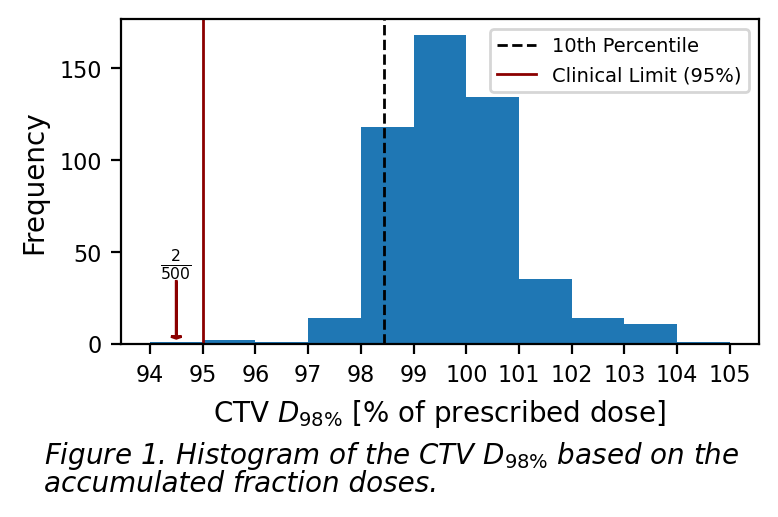

In [70]:
x_label = 'CTV $D_{98\%}$ [% of prescribed dose]'


# Desired pixel dimensions
width_px, height_px = 800, 600
dpi = 200  # resolution

# Convert pixels to inches
width_in = width_px / dpi
height_in = height_px / dpi

f, ax = plt.subplots(figsize=(width_in, height_in), dpi=dpi)

ax.hist(np.array(d98s)*100, bins=np.arange(94, 106, 1), density=False)
ax.set_xlabel(x_label)
ax.set_ylabel('Frequency')
ax.set_xticks(np.arange(94, 106.1, 1))
ax.tick_params(axis='both', which='major', labelsize=8)
#ax.tick_params(axis='both', which='minor', labelsize=8)


d98_10 = 100 * np.percentile(d98s, 10)
ax.axvline(d98_10, color='black', linestyle='dashed', linewidth=1)
ax.axvline(95, color='darkred', linewidth=1)
ax.legend([f'10th Percentile', 'Clinical Limit (95%)'], loc='upper right', fontsize=7)

ax.text(94.2, 40,  r'$\frac{2}{500}$', fontsize=8)
ax.arrow(94.5, 34, 0, -30, head_width=0.2, head_length=1, fc='darkred', ec='darkred')
ax.text(92, -65,  r'Figure 1. Histogram of the CTV $D_{98\%}$ based on the', fontsize=10, style='italic')
ax.text(92, -80,  r'accumulated fraction doses.', fontsize=10, style='italic')

f.tight_layout()

f.savefig('/mnt/P/TERAPI/FYSIKER/David_Tilly/DosePrediction/MarginSimulation/simulation_98_histogram.png', dpi=dpi, bbox_inches='tight')



np.min(np.array(d98s)*100)

(array([0.93692803, 0.94891017]), array([], dtype=float64))

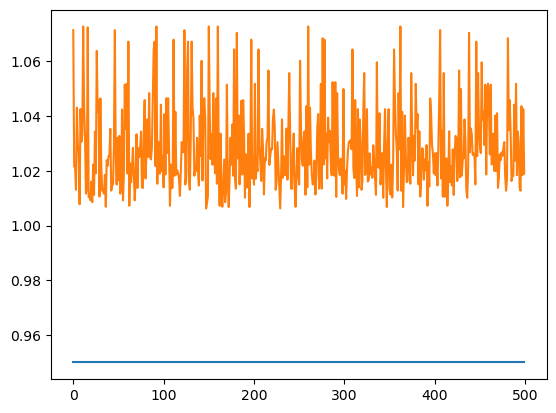

In [71]:
d98_nom = [result['PTV_D98_nominal'] for result in results ]
d2_nom = [result['PTV_D2_nominal'] for result in results ]
plt.plot(d98_nom)
plt.plot(d2_nom)

cases_low_d98 = [ [result['patient_id'], result['plan_label']]  for result in results if result['PTV_D98_nominal'] < 0.95 ]

d98s = np.array(d98s)
d98s[d98s < 0.95], d98s[d98s > 1.05]  


dict_keys(['PatientID', 'CinePath', 'PlanLabel', 'FractionDose', 'TimesTransversal', 'DisplacementTransversalX', 'DisplacementTransversalY', 'TimesSagittal', 'DisplacementSagittalY', 'DisplacementSagittalZ', 'TimesCoronal', 'DisplacementCoronalX', 'DisplacementCoronalZ', 'version'])


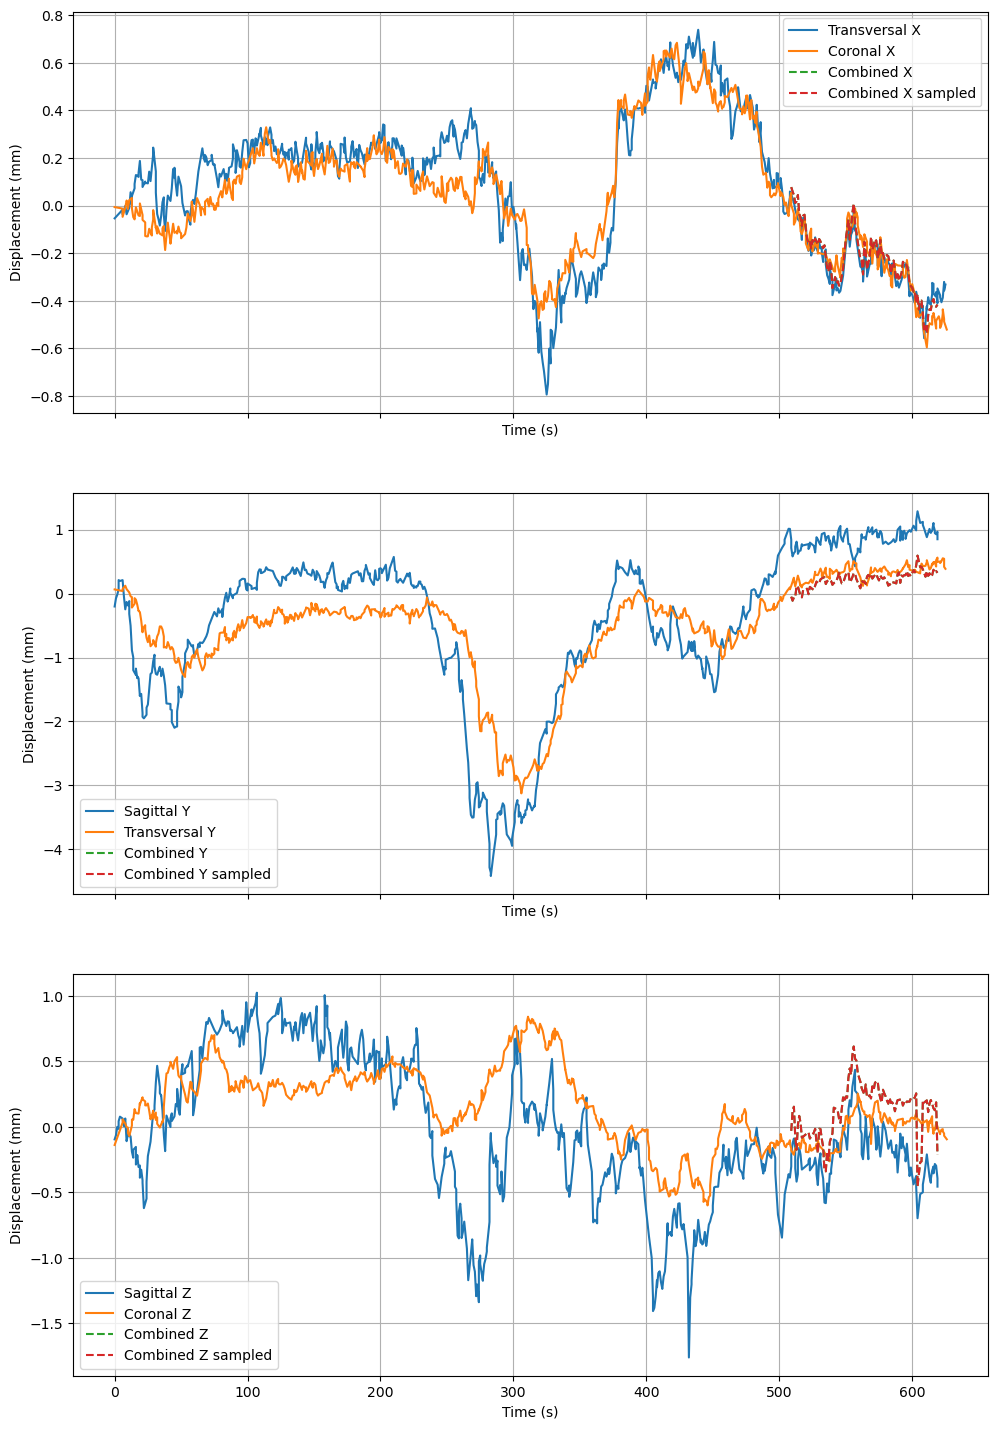

In [19]:
report = reports[('193211030873', '10MRL1ADT01')] 
print(report.keys())

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30/2.54, 45/2.54), sharex=True)

ax1.plot(report['TimesTransversal'], report['DisplacementTransversalX'], label='Transversal X')
ax1.plot(report['TimesCoronal'], report['DisplacementCoronalX'], label='Coronal X')
ax2.plot(report['TimesSagittal'], report['DisplacementSagittalY'], label='Sagittal Y')
ax2.plot(report['TimesTransversal'], report['DisplacementTransversalY'], label='Transversal Y')
ax3.plot(report['TimesSagittal'], report['DisplacementSagittalZ'], label='Sagittal Z')
ax3.plot(report['TimesCoronal'], report['DisplacementCoronalZ'], label='Coronal Z')

cut_time = cine_start_to_stop_time(report) - 110

times, motion_trace_0 = combine_cine_to_trace(report, treatment_time=110)
times, motion_trace_sampled = create_motion_trace(plan_ver_displacements, report, treatment_time=110)
ax1.plot(times + cut_time, motion_trace_0[:, 0], label='Combined X', ls='dashed')
ax2.plot(times + cut_time, motion_trace_0[:, 1], label='Combined Y', ls='dashed')
ax3.plot(times + cut_time, motion_trace_0[:, 2], label='Combined Z', ls='dashed')

ax1.plot(times + cut_time, motion_trace_sampled[:, 0], label='Combined X sampled', ls='dashed')
ax2.plot(times + cut_time, motion_trace_sampled[:, 1], label='Combined Y sampled', ls='dashed')
ax3.plot(times + cut_time, motion_trace_sampled[:, 2], label='Combined Z sampled', ls='dashed')

for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylabel('Displacement (mm)')
    ax.set_xlabel('Time (s)')
    ax.grid()

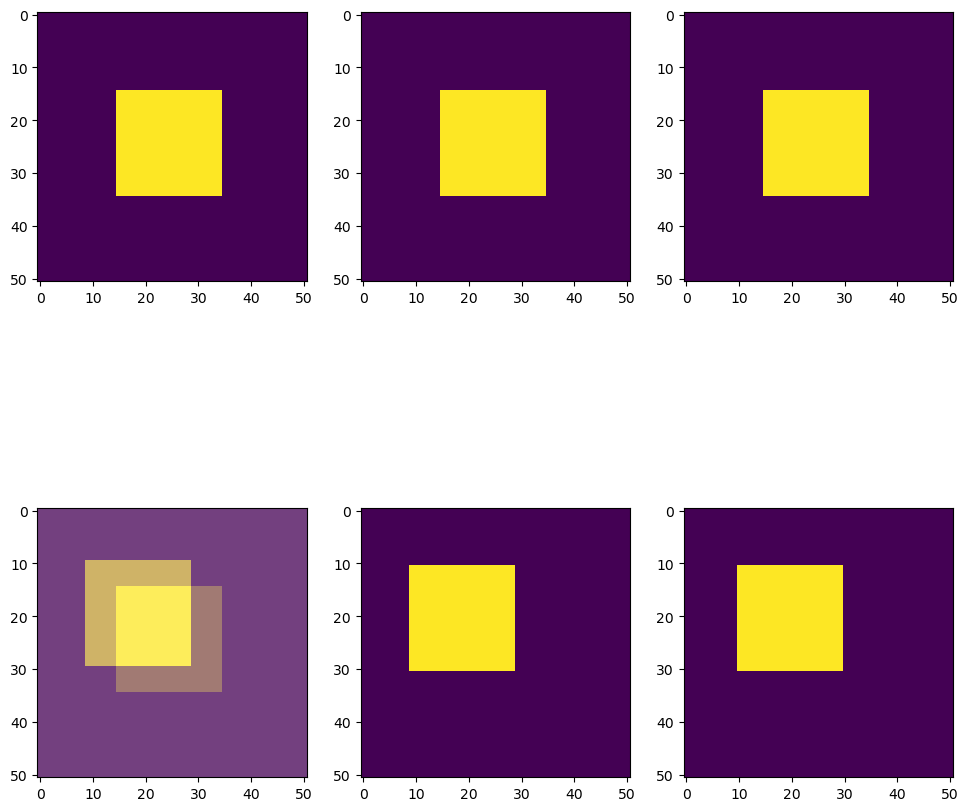

In [ ]:
import SimpleITK as sitk

dx = 4
dy = 5
dz = 6

dim = np.array([51, 51, 51])
nominal_dose = 0. * np.zeros(dim)
pos_000 = np.array([-25, -25, -25])
spacing = np.array([1, 1, 1])
grid = Grid3D(pos_000, spacing, dim)

nominal_dose[15:35, 15:35, 15:35] = 1.0  

    
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30/2.54, 30/2.54))
ax1.imshow(nominal_dose[25, :, :], vmin=0, vmax=1)
ax4.imshow(nominal_dose[25, :, :], vmin=0, vmax=1, alpha=0.5)
ax4.imshow(dose_now[25, :, :], vmin=0, vmax=1, alpha=0.5)

ax2.imshow(nominal_dose[:, 25, :], vmin=0, vmax=1)
ax5.imshow(dose_now[:, 25, :], vmin=0, vmax=1)  

ax3.imshow(nominal_dose[:, :,25], vmin=0, vmax=1)
ax6.imshow(dose_now[:, :, 25], vmin=0, vmax=1)